In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import random
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
AUTOTUNE = tf.data.experimental.AUTOTUNE
from sklearn.model_selection import GroupShuffleSplit 
import seaborn as sns
import sklearn.metrics as metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

random.seed(1)# setting random seed
np.random.seed(1)
tf.random.set_seed(1)
main_data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

In [2]:
# One-hot encoding the cellTypeName column for ease of use in model creation

cancerTypes = ['epithelial', 'inflammatory', 'fibroblast', 'others']
cancerous = ["Y", "N"]

one_hot = pd.get_dummies(main_data['cellTypeName'])
main_data = main_data.join(one_hot)

main_data
# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,epithelial,fibroblast,inflammatory,others
0,22405,1,22405.png,fibroblast,0,0,0,1,0,0
1,22406,1,22406.png,fibroblast,0,0,0,1,0,0
2,22407,1,22407.png,fibroblast,0,0,0,1,0,0
3,22408,1,22408.png,fibroblast,0,0,0,1,0,0
4,22409,1,22409.png,fibroblast,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1,1,0,0,0
9892,1626,60,1626.png,epithelial,2,1,1,0,0,0
9893,1627,60,1627.png,epithelial,2,1,1,0,0,0
9894,1628,60,1628.png,epithelial,2,1,1,0,0,0


In [3]:
main_data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
epithelial      0
fibroblast      0
inflammatory    0
others          0
dtype: int64

In [4]:
def stratified_resampling_within_group(data, stratify_col):
    # Check if all classes are represented in the group
    if len(data[stratify_col].unique()) == 1:
        # Only one class is represented, no need for resampling
        return data
    else:
        # More than one class are represented, apply resampling
        max_size = data[stratify_col].value_counts().max()
        lst = [data]
        for class_index, group in data.groupby(stratify_col):
            lst.append(group.sample(max_size-len(group), replace=True))
        return pd.concat(lst)

# First split the data into training, validation, and test sets without considering 'cellTypeName'
train_test_ix, val_ix = next(GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42).split(main_data, groups=main_data["patientID"]))
train_test = main_data.loc[train_test_ix]
val = main_data.loc[val_ix]

train_test = train_test.reset_index(drop=True)
train_ix, test_ix = next(GroupShuffleSplit(n_splits=1, train_size=.75, random_state=42).split(train_test, groups=train_test["patientID"]))
train = train_test.loc[train_ix]
test = train_test.loc[test_ix]

# Apply stratified resampling within test set
train = stratified_resampling_within_group(train, 'cellTypeName')

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70')])

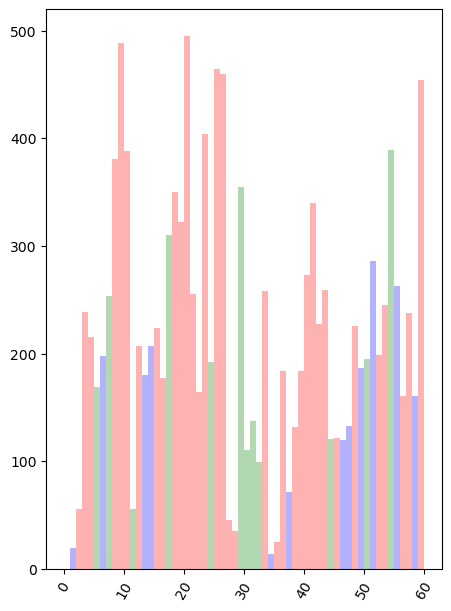

In [5]:
# Displaying image distribution for patient ID amongs splits
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.tight_layout(pad=4.0)
plt.hist(x=train['patientID'], alpha=0.3, color='r', bins=60,range=(0,60))
plt.hist(x=val['patientID'], alpha=0.3, color='b', bins=60, range=(0,60))
plt.hist(x=test['patientID'], alpha=0.3, color='g', bins=60, range=(0,60))
plt.xticks(rotation=60)

In [6]:
#Drop the unused columns from the data
main_data = main_data.drop('cellTypeName',axis = 1)
main_data = main_data.drop('cellType',axis = 1)

# Admin Work

In [7]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4
BATCH_SIZE = 256
EPOCHS = 100
LEARNING_RATE = 0.001

In [8]:
# Turning the dataset images into images usable for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

train_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Setting up the generators
train_generator = train_gen.flow_from_dataframe(
        dataframe=train,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col=['epithelial', 'inflammatory', 'fibroblast', 'others'],
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='raw')

validation_generator = val_gen.flow_from_dataframe(
        dataframe=val,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col=['epithelial', 'inflammatory', 'fibroblast', 'others'],
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='raw')

test_generator = test_gen.flow_from_dataframe(
        dataframe=test,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col=['epithelial', 'inflammatory', 'fibroblast', 'others'],
        target_size=(27, 27),
        batch_size=1,
        class_mode='raw')

#Apply weights for classes
class_weights = {}

# calculate class weights
for i, column in enumerate(['epithelial', 'inflammatory', 'fibroblast', 'others']):
    class_weights[i] = np.sum(train[column] == 1) / len(train[column])

# normalize class weights
sum_weights = sum(class_weights.values())
class_weights = {k: v/sum_weights for k, v in class_weights.items()}

print(class_weights)

Found 8896 validated image filenames.
Found 1839 validated image filenames.
Found 2386 validated image filenames.
{0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}


# Baseline

In [9]:
#Baseline NN model with input, flatten, and output
model = tf.keras.Sequential([
    layers.Flatten(input_shape=INPUT_DIM),
    layers.Dense(HIDDEN_LAYER_DIM, activation="relu"),
    layers.Dense(OUTPUT_CLASSES, activation="softmax")
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


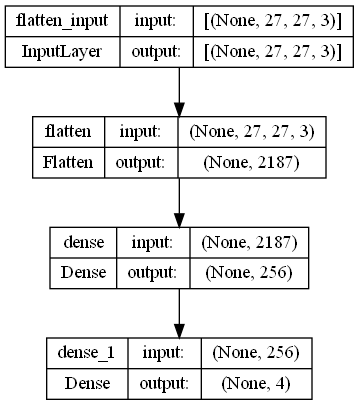

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
from keras.optimizers import SGD
opt = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer = opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.CategoricalAccuracy(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()
              ]
             )

history = model.fit(train_generator, validation_data = validation_generator,class_weight=class_weights, epochs=EPOCHS)

Epoch 1/100
35/35 [==============================] - 4s 79ms/step - loss: 0.3429 - categorical_accuracy: 0.3255 - precision: 0.6667 - recall: 2.2482e-04 - val_loss: 1.3503 - val_categorical_accuracy: 0.3469 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
35/35 [==============================] - 2s 68ms/step - loss: 0.3379 - categorical_accuracy: 0.3477 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3556 - val_categorical_accuracy: 0.3208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
35/35 [==============================] - 2s 64ms/step - loss: 0.3361 - categorical_accuracy: 0.3597 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3530 - val_categorical_accuracy: 0.3203 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
35/35 [==============================] - 2s 55ms/step - loss: 0.3344 - categorical_accuracy: 0.3706 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3436 - val_categorical_accuracy: 0.3507 -

35/35 [==============================] - 2s 58ms/step - loss: 0.3121 - categorical_accuracy: 0.5252 - precision: 1.0000 - recall: 0.0012 - val_loss: 1.2569 - val_categorical_accuracy: 0.5106 - val_precision: 1.0000 - val_recall: 5.4377e-04
Epoch 33/100
35/35 [==============================] - 2s 55ms/step - loss: 0.3117 - categorical_accuracy: 0.5275 - precision: 1.0000 - recall: 0.0013 - val_loss: 1.2500 - val_categorical_accuracy: 0.5394 - val_precision: 1.0000 - val_recall: 5.4377e-04
Epoch 34/100
35/35 [==============================] - 2s 58ms/step - loss: 0.3112 - categorical_accuracy: 0.5283 - precision: 1.0000 - recall: 0.0015 - val_loss: 1.2552 - val_categorical_accuracy: 0.5171 - val_precision: 1.0000 - val_recall: 5.4377e-04
Epoch 35/100
35/35 [==============================] - 2s 55ms/step - loss: 0.3106 - categorical_accuracy: 0.5239 - precision: 1.0000 - recall: 0.0015 - val_loss: 1.2445 - val_categorical_accuracy: 0.5367 - val_precision: 1.0000 - val_recall: 5.4377e-04
E

Epoch 65/100
35/35 [==============================] - 2s 54ms/step - loss: 0.2960 - categorical_accuracy: 0.5713 - precision: 0.8593 - recall: 0.0192 - val_loss: 1.1804 - val_categorical_accuracy: 0.5938 - val_precision: 0.9677 - val_recall: 0.0163
Epoch 66/100
35/35 [==============================] - 2s 59ms/step - loss: 0.2955 - categorical_accuracy: 0.5722 - precision: 0.8685 - recall: 0.0208 - val_loss: 1.1787 - val_categorical_accuracy: 0.5900 - val_precision: 0.9429 - val_recall: 0.0179
Epoch 67/100
35/35 [==============================] - 2s 56ms/step - loss: 0.2951 - categorical_accuracy: 0.5716 - precision: 0.8685 - recall: 0.0208 - val_loss: 1.1780 - val_categorical_accuracy: 0.5943 - val_precision: 0.9459 - val_recall: 0.0190
Epoch 68/100
35/35 [==============================] - 2s 54ms/step - loss: 0.2946 - categorical_accuracy: 0.5746 - precision: 0.8776 - recall: 0.0242 - val_loss: 1.1843 - val_categorical_accuracy: 0.5829 - val_precision: 0.9333 - val_recall: 0.0152
Epoc

Epoch 98/100
35/35 [==============================] - 2s 57ms/step - loss: 0.2835 - categorical_accuracy: 0.5864 - precision: 0.8623 - recall: 0.0619 - val_loss: 1.1395 - val_categorical_accuracy: 0.6090 - val_precision: 0.8968 - val_recall: 0.0614
Epoch 99/100
35/35 [==============================] - 2s 56ms/step - loss: 0.2832 - categorical_accuracy: 0.5863 - precision: 0.8683 - recall: 0.0623 - val_loss: 1.1340 - val_categorical_accuracy: 0.6096 - val_precision: 0.9124 - val_recall: 0.0680
Epoch 100/100
35/35 [==============================] - 2s 59ms/step - loss: 0.2829 - categorical_accuracy: 0.5859 - precision: 0.8683 - recall: 0.0623 - val_loss: 1.1294 - val_categorical_accuracy: 0.6199 - val_precision: 0.9097 - val_recall: 0.0712


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


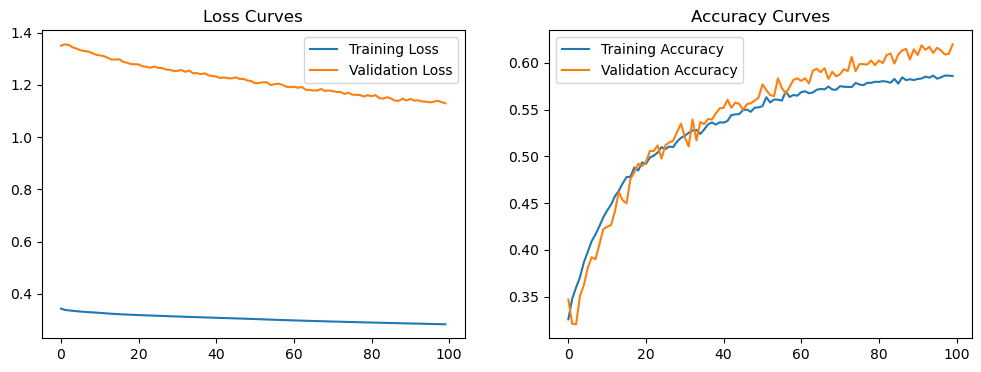

Final training loss: 1.13054621219635
Final training accuracy: 0.5884667038917542
Final validation loss: 1.129367470741272
Final validation accuracy: 0.6199021339416504


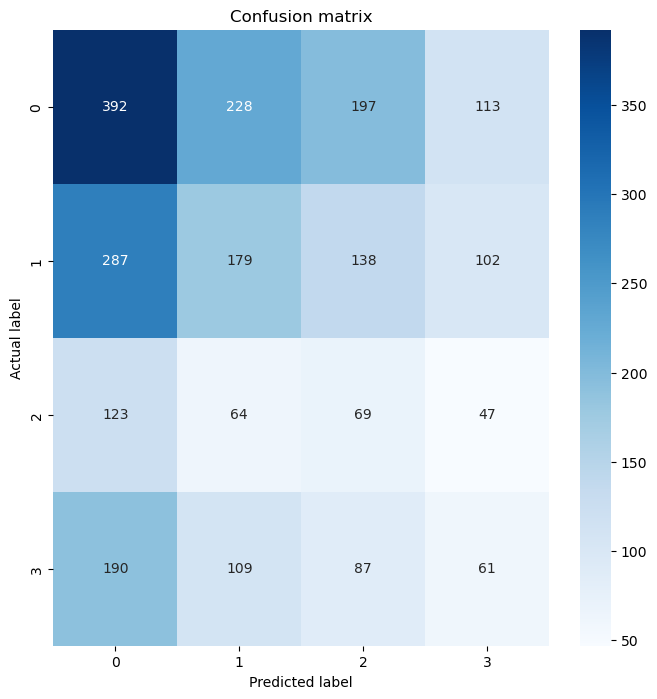

              precision    recall  f1-score   support

  epithelial       0.40      0.42      0.41       930
inflammatory       0.31      0.25      0.28       706
  fibroblast       0.14      0.23      0.17       303
      others       0.19      0.14      0.16       447

    accuracy                           0.29      2386
   macro avg       0.26      0.26      0.25      2386
weighted avg       0.30      0.29      0.29      2386



In [13]:
#Plotting results for baseline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np

# 1. Model architecture
model.summary()

# 2. Training and validation loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()

# 3. Final training and validation loss/accuracy
train_eval = model.evaluate(train_generator, verbose=0)
val_eval = model.evaluate(validation_generator, verbose=0)

# train_eval and val_eval are lists with the loss value at index 0 and the metrics values thereafter
final_train_loss, final_train_accuracy = train_eval[0], train_eval[1]
final_val_loss, final_val_accuracy = val_eval[0], val_eval[1]

print(f"Final training loss: {final_train_loss}")
print(f"Final training accuracy: {final_train_accuracy}")
print(f"Final validation loss: {final_val_loss}")
print(f"Final validation accuracy: {final_val_accuracy}")

# 4. Confusion matrix and classification report
# predict the output from the model
predictions = model.predict(test_generator, steps=len(test_generator), verbose=0)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the true classes
y_true = test[['epithelial', 'inflammatory', 'fibroblast', 'others']].values.argmax(axis=1)

# get class labels
class_labels = ['epithelial', 'inflammatory', 'fibroblast', 'others']

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# print classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

# CNN
Next comes applying a CNN to try further optimize our Base model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

#Create new CNN model
model = tf.keras.Sequential([
    # First convolutional layer. Learn 64 filters using a 3x3 kernel
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),

    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),

    # Batch normalization
    layers.BatchNormalization(),

    # Max pooling layer
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Dropout layer
    layers.Dropout(0.25),

    # Third and Fourth convolutional layer. Increase to 128 filters.
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),

    # Second Batch normalization
    layers.BatchNormalization(),

    # Second Max pooling layer
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Dropout layer
    layers.Dropout(0.25),

    # Fifth and Sixth convolutional layer. Further increase to 256 filters.
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),

    # Third Batch normalization
    layers.BatchNormalization(),

    # Third Max pooling layer
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Dropout layer
    layers.Dropout(0.25),

    # Flatten layer to feed into the Dense layer
    layers.Flatten(),

    # Dense layers
    layers.Dense(HIDDEN_LAYER_DIM, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(HIDDEN_LAYER_DIM // 2, activation="relu"),
    layers.Dense(OUTPUT_CLASSES, activation="softmax")
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)      

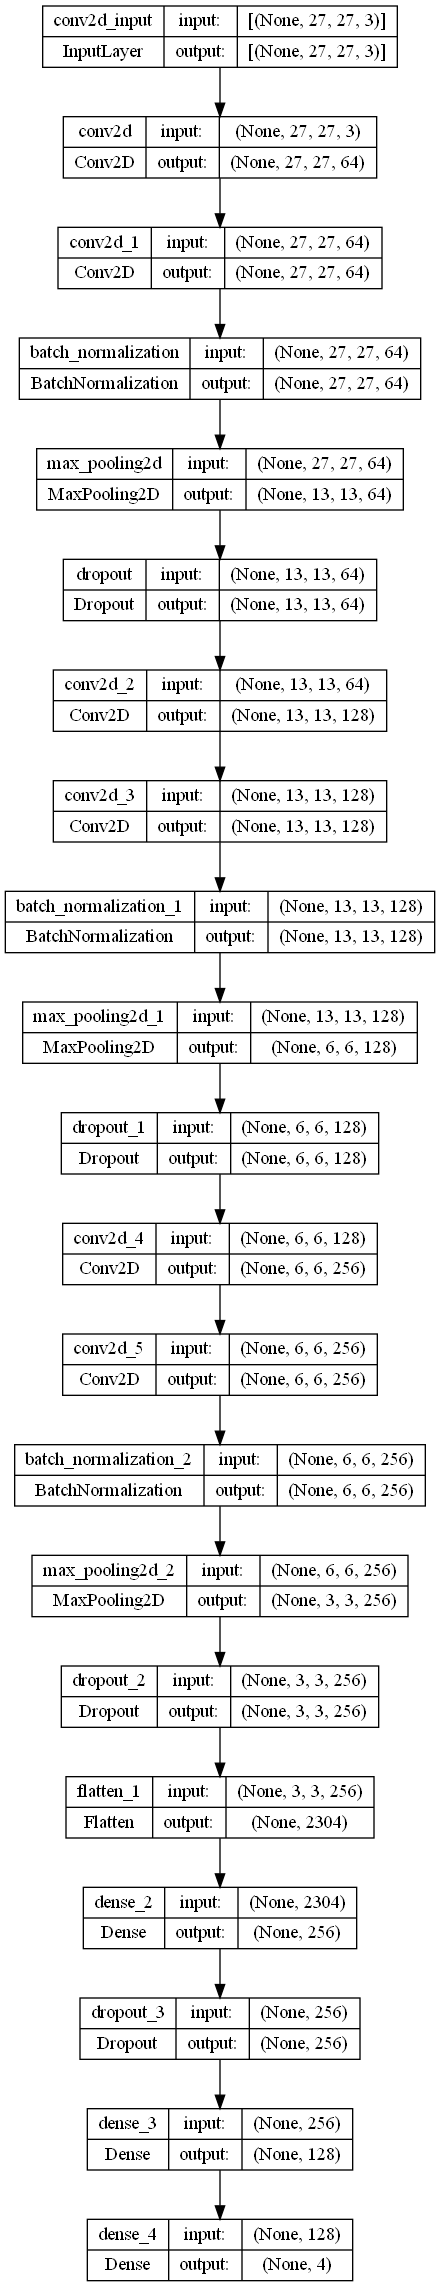

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
#Define augmented image generator
augmented_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
augmented_generator = augmented_gen.flow_from_dataframe(
        dataframe=train,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col=['epithelial', 'inflammatory', 'fibroblast', 'others'],
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='raw')

# Define custom train_on_batches generator
def train_on_batches():
    while True:
        for (orig_images, orig_labels), (aug_images, aug_labels) in zip(train_generator, augmented_generator):
            yield (np.concatenate((orig_images, aug_images)), np.concatenate((orig_labels, aug_labels)))

# Combine the original_generator and augmented_generator batch sizes
BATCH_SIZE_COMBINED = BATCH_SIZE * 2

# Prepare the custom train_on_batches generator
train_batches = train_on_batches()

# Calculate steps per epoch for the combined generator
steps_per_epoch_combined = (train_generator.samples + augmented_generator.samples) // BATCH_SIZE_COMBINED

Found 8896 validated image filenames.


In [18]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

opt = SGD(learning_rate=LEARNING_RATE)

model.compile(optimizer = opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.CategoricalAccuracy(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()
              ]
             )

# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    mode='min',  # We seek to minimize the validation loss
    patience=20,  # Number of epochs to wait without improvement before stopping the training
    verbose=1,
    restore_best_weights=True  # Restore the best weights recorded during training
)

# Define the ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.1,  # Reduce learning rate by this factor
    patience=10,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,  
    min_delta=1e-4,  # Minimum change in the monitored quantity to qualify as an improvement
    min_lr=1e-6,  # Lower bound on the learning rate
)

history = model.fit(
    train_batches, 
    validation_data=validation_generator, 
    steps_per_epoch=steps_per_epoch_combined,
    class_weight=class_weights,
    epochs=EPOCHS,
    callbacks=[early_stopping_callback, reduce_lr_callback]
)

num_epochs_run = len(history.history['loss'])

Epoch 1/100
34/34 [==============================] - 13s 174ms/step - loss: 0.5580 - categorical_accuracy: 0.2687 - precision_1: 0.2757 - recall_1: 0.2102 - val_loss: 1.3904 - val_categorical_accuracy: 0.1419 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 0.0010
Epoch 2/100
34/34 [==============================] - 8s 150ms/step - loss: 0.4996 - categorical_accuracy: 0.2954 - precision_1: 0.3047 - recall_1: 0.2215 - val_loss: 1.4035 - val_categorical_accuracy: 0.1419 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 0.0010
Epoch 3/100
34/34 [==============================] - 6s 183ms/step - loss: 0.4633 - categorical_accuracy: 0.3204 - precision_1: 0.3368 - recall_1: 0.2412 - val_loss: 1.4194 - val_categorical_accuracy: 0.1419 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 0.0010
Epoch 4/100
34/34 [==============================] - 7s 192ms/step - loss: 0.4428 - categorical_accuracy: 0.3359 - precision_1: 0.3501 - recall_1: 0.2466 - val_loss:

Epoch 30/100
34/34 [==============================] - 9s 264ms/step - loss: 0.3456 - categorical_accuracy: 0.4296 - precision_1: 0.4714 - recall_1: 0.3207 - val_loss: 0.9699 - val_categorical_accuracy: 0.6297 - val_precision_1: 0.8537 - val_recall_1: 0.3806 - lr: 1.0000e-04
Epoch 31/100
34/34 [==============================] - 8s 246ms/step - loss: 0.3424 - categorical_accuracy: 0.4339 - precision_1: 0.4779 - recall_1: 0.3259 - val_loss: 0.9663 - val_categorical_accuracy: 0.6286 - val_precision_1: 0.8559 - val_recall_1: 0.3877 - lr: 1.0000e-04
Epoch 32/100
34/34 [==============================] - 9s 265ms/step - loss: 0.3423 - categorical_accuracy: 0.4306 - precision_1: 0.4723 - recall_1: 0.3197 - val_loss: 0.9639 - val_categorical_accuracy: 0.6324 - val_precision_1: 0.8555 - val_recall_1: 0.3926 - lr: 1.0000e-04
Epoch 33/100
34/34 [==============================] - 11s 329ms/step - loss: 0.3388 - categorical_accuracy: 0.4391 - precision_1: 0.4807 - recall_1: 0.3275 - val_loss: 0.9645 

Epoch 60/100
34/34 [==============================] - 12s 370ms/step - loss: 0.3297 - categorical_accuracy: 0.4498 - precision_1: 0.4984 - recall_1: 0.3402 - val_loss: 0.9379 - val_categorical_accuracy: 0.6351 - val_precision_1: 0.8593 - val_recall_1: 0.4350 - lr: 1.0000e-04
Epoch 61/100
34/34 [==============================] - 9s 270ms/step - loss: 0.3270 - categorical_accuracy: 0.4600 - precision_1: 0.5056 - recall_1: 0.3441 - val_loss: 0.9382 - val_categorical_accuracy: 0.6357 - val_precision_1: 0.8593 - val_recall_1: 0.4350 - lr: 1.0000e-04
Epoch 62/100
34/34 [==============================] - 10s 287ms/step - loss: 0.3278 - categorical_accuracy: 0.4552 - precision_1: 0.5017 - recall_1: 0.3457 - val_loss: 0.9362 - val_categorical_accuracy: 0.6362 - val_precision_1: 0.8574 - val_recall_1: 0.4350 - lr: 1.0000e-04
Epoch 63/100
34/34 [==============================] - 10s 298ms/step - loss: 0.3224 - categorical_accuracy: 0.4641 - precision_1: 0.5109 - recall_1: 0.3474 - val_loss: 0.934

Epoch 90/100
34/34 [==============================] - 9s 284ms/step - loss: 0.3104 - categorical_accuracy: 0.4790 - precision_1: 0.5301 - recall_1: 0.3640 - val_loss: 0.9152 - val_categorical_accuracy: 0.6368 - val_precision_1: 0.8590 - val_recall_1: 0.4573 - lr: 1.0000e-04
Epoch 91/100
34/34 [==============================] - 10s 303ms/step - loss: 0.3139 - categorical_accuracy: 0.4717 - precision_1: 0.5219 - recall_1: 0.3573 - val_loss: 0.9137 - val_categorical_accuracy: 0.6373 - val_precision_1: 0.8586 - val_recall_1: 0.4557 - lr: 1.0000e-04
Epoch 92/100
34/34 [==============================] - 9s 256ms/step - loss: 0.3110 - categorical_accuracy: 0.4787 - precision_1: 0.5294 - recall_1: 0.3615 - val_loss: 0.9121 - val_categorical_accuracy: 0.6368 - val_precision_1: 0.8582 - val_recall_1: 0.4573 - lr: 1.0000e-04
Epoch 93/100
34/34 [==============================] - 9s 279ms/step - loss: 0.3114 - categorical_accuracy: 0.4794 - precision_1: 0.5322 - recall_1: 0.3644 - val_loss: 0.9116 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)      

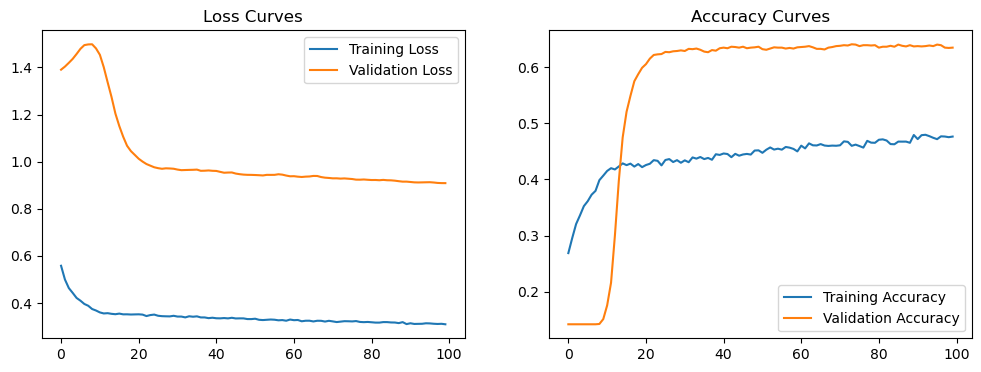

Final training loss: 1.0003705024719238
Final training accuracy: 0.5725045204162598
Final validation loss: 0.9087821245193481
Final validation accuracy: 0.6345840096473694


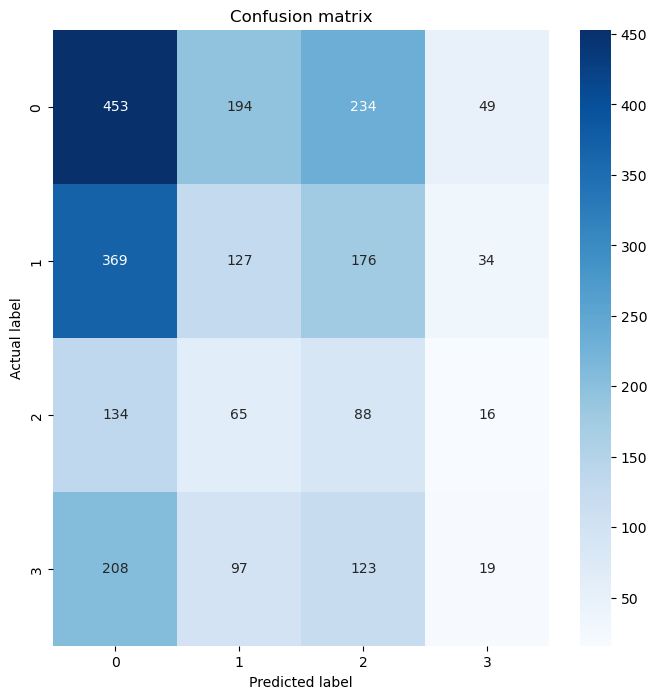

              precision    recall  f1-score   support

  epithelial       0.39      0.49      0.43       930
inflammatory       0.26      0.18      0.21       706
  fibroblast       0.14      0.29      0.19       303
      others       0.16      0.04      0.07       447

    accuracy                           0.29      2386
   macro avg       0.24      0.25      0.23      2386
weighted avg       0.28      0.29      0.27      2386



In [19]:
#Plot results of new model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np

# 1. Model architecture
model.summary()

# 2. Training and validation loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()

# 3. Final training and validation loss/accuracy
train_eval = model.evaluate(train_generator, verbose=0)
val_eval = model.evaluate(validation_generator, verbose=0)

# train_eval and val_eval are lists with the loss value at index 0 and the metrics values thereafter
final_train_loss, final_train_accuracy = train_eval[0], train_eval[1]
final_val_loss, final_val_accuracy = val_eval[0], val_eval[1]

print(f"Final training loss: {final_train_loss}")
print(f"Final training accuracy: {final_train_accuracy}")
print(f"Final validation loss: {final_val_loss}")
print(f"Final validation accuracy: {final_val_accuracy}")

# 4. Confusion matrix and classification report
# predict the output from the model
predictions = model.predict(test_generator, steps=len(test_generator), verbose=0)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the true classes
y_true = test[['epithelial', 'inflammatory', 'fibroblast', 'others']].values.argmax(axis=1)

# get class labels
class_labels = ['epithelial', 'inflammatory', 'fibroblast', 'others']

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# print classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


In [20]:
#Print evaluation results
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=128)

# Unpack the results
test_loss, test_accuracy, test_precision, test_recall = results

print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test Recall: {test_recall:.3f}")

Evaluate on test data
2386/2386 [==============================] - 12s 5ms/step - loss: 0.9130 - categorical_accuracy: 0.6262 - precision_1: 0.7440 - recall_1: 0.4434
Test Loss: 0.913
Test Accuracy: 62.62%
Test Precision: 0.744
Test Recall: 0.443


# Applying Transfer Learning

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

# Load the trained "isCancerous" model
isCancerous_model = load_model('./Model/isCancerous.h5')

# Create a new model, by removing the last three layers (Flatten, Dense and Dropout) from the "isCancerous" model
base_model = Model(inputs=isCancerous_model.inputs, outputs=isCancerous_model.layers[-4].output)

# Make sure the base model is not trainable
for layer in base_model.layers:
    layer.trainable = False

# Now, add new layers specific to the "cellType" task

# Add dense layers
dense1 = Dense(256, activation='relu')(base_model.output)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)

# Output layer
output = Dense(4, activation='softmax')(dense2)

# Define new model
tlModel = Model(inputs=base_model.inputs, outputs=output)

In [22]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

opt = SGD(learning_rate=LEARNING_RATE)

tlModel.compile(optimizer = opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[
                  tf.keras.metrics.CategoricalAccuracy(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall()
              ]
             )

# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    mode='min',  # We seek to minimize the validation loss
    patience=20,  # Number of epochs to wait without improvement before stopping the training
    verbose=1,
    restore_best_weights=True  # Restore the best weights recorded during training
)

# Define the ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.1,  # Reduce learning rate by this factor
    patience=10,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,  
    min_delta=1e-4,  # Minimum change in the monitored quantity to qualify as an improvement
    min_lr=1e-6,  # Lower bound on the learning rate
)

history = tlModel.fit(
    train_batches, 
    validation_data=validation_generator, 
    steps_per_epoch=steps_per_epoch_combined,
    class_weight=class_weights,
    epochs=EPOCHS,
    callbacks=[early_stopping_callback, reduce_lr_callback]
)

num_epochs_run = len(history.history['loss'])

Epoch 1/100
34/34 [==============================] - 11s 314ms/step - loss: 0.3473 - categorical_accuracy: 0.2439 - precision_2: 1.0000 - recall_2: 1.7361e-04 - val_loss: 1.4725 - val_categorical_accuracy: 0.1147 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 2/100
34/34 [==============================] - 9s 280ms/step - loss: 0.3473 - categorical_accuracy: 0.2482 - precision_2: 0.8000 - recall_2: 2.3148e-04 - val_loss: 1.4705 - val_categorical_accuracy: 0.1136 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 3/100
34/34 [==============================] - 9s 264ms/step - loss: 0.3475 - categorical_accuracy: 0.2425 - precision_2: 0.6000 - recall_2: 1.7361e-04 - val_loss: 1.4684 - val_categorical_accuracy: 0.1180 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 4/100
34/34 [==============================] - 9s 278ms/step - loss: 0.3464 - categorical_accuracy: 0.2499 - precision_2: 0.8750 - recall_2: 4.0509

Epoch 30/100
34/34 [==============================] - 6s 191ms/step - loss: 0.3405 - categorical_accuracy: 0.2687 - precision_2: 0.6667 - recall_2: 3.4722e-04 - val_loss: 1.4192 - val_categorical_accuracy: 0.1251 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 31/100
34/34 [==============================] - 7s 201ms/step - loss: 0.3400 - categorical_accuracy: 0.2718 - precision_2: 0.7000 - recall_2: 4.0509e-04 - val_loss: 1.4176 - val_categorical_accuracy: 0.1262 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 32/100
34/34 [==============================] - 6s 193ms/step - loss: 0.3398 - categorical_accuracy: 0.2715 - precision_2: 0.6000 - recall_2: 1.7361e-04 - val_loss: 1.4159 - val_categorical_accuracy: 0.1262 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 33/100
34/34 [==============================] - 6s 192ms/step - loss: 0.3396 - categorical_accuracy: 0.2703 - precision_2: 0.8462 - recall_2: 6.3

Epoch 59/100
34/34 [==============================] - 6s 176ms/step - loss: 0.3339 - categorical_accuracy: 0.3113 - precision_2: 0.9474 - recall_2: 0.0010 - val_loss: 1.3737 - val_categorical_accuracy: 0.2316 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 60/100
34/34 [==============================] - 6s 182ms/step - loss: 0.3338 - categorical_accuracy: 0.3165 - precision_2: 1.0000 - recall_2: 3.4722e-04 - val_loss: 1.3723 - val_categorical_accuracy: 0.2393 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 61/100
34/34 [==============================] - 6s 186ms/step - loss: 0.3338 - categorical_accuracy: 0.3179 - precision_2: 0.8571 - recall_2: 0.0010 - val_loss: 1.3708 - val_categorical_accuracy: 0.2480 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 62/100
34/34 [==============================] - 6s 188ms/step - loss: 0.3328 - categorical_accuracy: 0.3206 - precision_2: 0.9231 - recall_2: 0.0014 - va

34/34 [==============================] - 6s 181ms/step - loss: 0.3278 - categorical_accuracy: 0.3683 - precision_2: 0.8148 - recall_2: 0.0013 - val_loss: 1.3325 - val_categorical_accuracy: 0.4040 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 89/100
34/34 [==============================] - 6s 183ms/step - loss: 0.3279 - categorical_accuracy: 0.3681 - precision_2: 0.9200 - recall_2: 0.0013 - val_loss: 1.3310 - val_categorical_accuracy: 0.4084 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 90/100
34/34 [==============================] - 6s 178ms/step - loss: 0.3274 - categorical_accuracy: 0.3758 - precision_2: 0.8519 - recall_2: 0.0013 - val_loss: 1.3297 - val_categorical_accuracy: 0.4122 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 91/100
34/34 [==============================] - 6s 193ms/step - loss: 0.3275 - categorical_accuracy: 0.3745 - precision_2: 0.8529 - recall_2: 0.0017 - val_loss: 1.3283 - 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3_input (InputLayer)  [(None, 27, 27, 3)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 512)         2954

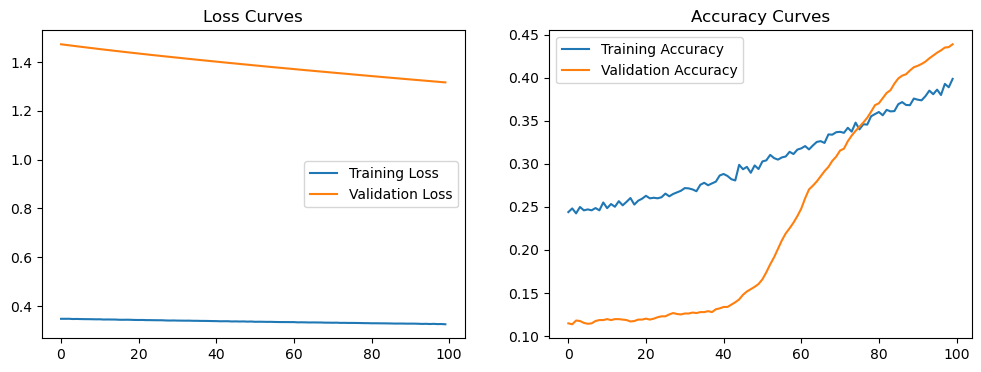

Final training loss: 1.2805317640304565
Final training accuracy: 0.4685251712799072
Final validation loss: 1.316254734992981
Final validation accuracy: 0.43882545828819275


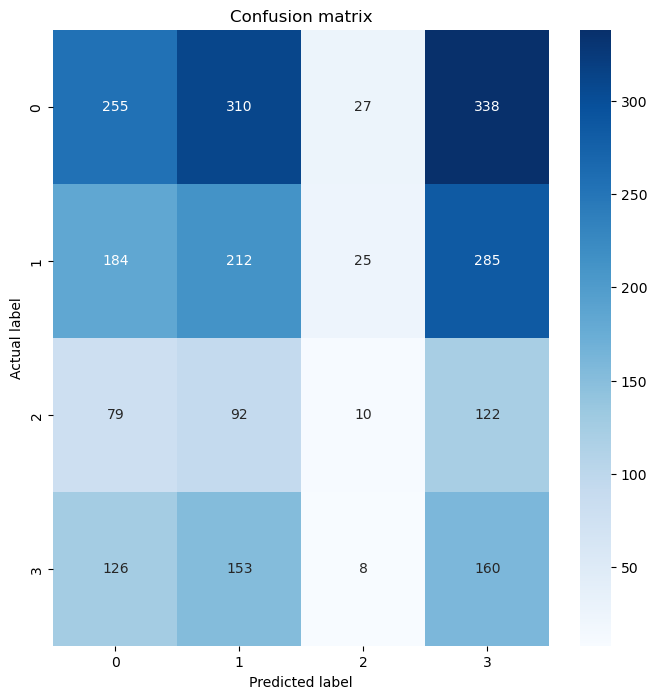

              precision    recall  f1-score   support

  epithelial       0.40      0.27      0.32       930
inflammatory       0.28      0.30      0.29       706
  fibroblast       0.14      0.03      0.05       303
      others       0.18      0.36      0.24       447

    accuracy                           0.27      2386
   macro avg       0.25      0.24      0.23      2386
weighted avg       0.29      0.27      0.26      2386



In [23]:
#Plot results of new model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np

# 1. Model architecture
tlModel.summary()

# 2. Training and validation loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()

# 3. Final training and validation loss/accuracy
train_eval = tlModel.evaluate(train_generator, verbose=0)
val_eval = tlModel.evaluate(validation_generator, verbose=0)

# train_eval and val_eval are lists with the loss value at index 0 and the metrics values thereafter
final_train_loss, final_train_accuracy = train_eval[0], train_eval[1]
final_val_loss, final_val_accuracy = val_eval[0], val_eval[1]

print(f"Final training loss: {final_train_loss}")
print(f"Final training accuracy: {final_train_accuracy}")
print(f"Final validation loss: {final_val_loss}")
print(f"Final validation accuracy: {final_val_accuracy}")

# 4. Confusion matrix and classification report
# predict the output from the model
predictions = tlModel.predict(test_generator, steps=len(test_generator), verbose=0)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the true classes
y_true = test[['epithelial', 'inflammatory', 'fibroblast', 'others']].values.argmax(axis=1)

# get class labels
class_labels = ['epithelial', 'inflammatory', 'fibroblast', 'others']

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# print classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

In [24]:
#Print evaluation results
print("Evaluate on test data")
results = tlModel.evaluate(test_generator, batch_size=128)

# Unpack the results
test_loss, test_accuracy, test_precision, test_recall = results

print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test Recall: {test_recall:.3f}")

Evaluate on test data
2386/2386 [==============================] - 6s 2ms/step - loss: 1.2757 - categorical_accuracy: 0.5708 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Test Loss: 1.276
Test Accuracy: 57.08%
Test Precision: 0.000
Test Recall: 0.000
